#  A mixed-integer programming model for an integrated production planning problem with preventive maintenance in the pulp and paper industry.

Production planning and scheduling in the pulp and paper industry can be very challenging. In most cases, practitioners address the production planning process manually, which is time-consuming and sub-optimal. This study deals with production planning encountered in a pulp mill company involving different wood species, parallel heterogeneous lines, inventory limits, sequence-independent setup times and preventive maintenance. To tackle the problem, an efficient mixed-integer formulation is proposed that optimizes when, where and how much to produce of different wood species and schedules preventive maintenance to minimize the total setup times. Several computational experiments are conducted to solve a case study in a pulp mill company in Chile. The results show the capability of the model to support the decision-making process in the pulp and paper industry, providing an efficient tool for practitioners to solve the problem in a reasonable amount of time.

#### Libraries

In [1]:
import gurobipy as gp
from gurobipy import GRB
import time
import matplotlib.pyplot as plt
import numpy as np

#### Create the Gurobi Model

In [2]:
mdl = gp.Model("model")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-14


#### Parameters

In [3]:
Lines = 3  # Number of Production Lines
Species = 3  # Number of Species
Days = 30  # Horizon (Days)
Trimestral_day = [4, 11, 18, 24]  # Days Available for Quarterly Maintenance
Maintenance_day = [0, 7, 14, 21, 28]  # Days Available for Monthly Maintenance

T = 24  # Number of Hours in a Day
Time_maintenance = 12  # Duration of the Maintenance (Hours)
Time_trimestral = 24  # Duration of the Quarterly Maintenance (Hours)
Dtri = 4  # Number of Consecutive Days for Quarterly Maintenance
S = 4  # Extra Days to Index Quarterly Maintenance

# Performance (m3/h)
Re = [[150, 90, 90], [150, 90, 90], [150, 80, 80]]  # Performance per Line and Species

# Demand
Demand = [[6500, 700, 2300] for _ in range(Days)]  # Demand of Each Species per Day

# External Supply
External_supply = [
    [2500, 0, 0] if day % 6 not in [5, 6] else [1000, 0, 0] for day in range(1, Days + 1)
]  # External Supply of Each Species

# Inventories
Initial_inventory = [17000, 17000, 6000]  # Initial Inventory
Minimum_inventory = [5700, 4600, 1000]  # Minimum Inventory
Maximum_inventory = [25000, 20000, 7000]  # Maximum Inventory

Disclaimer: This data is fictitious and created solely for illustrative purposes. 

#### Variables 

In [4]:
# x[i,k,j]: integer hours of production of species i on line k, day j
x = mdl.addVars(range(Species),range(Lines),range(Days),vtype=GRB.INTEGER,name="x")

# s[k,j]: integer number of setups performed on line k on day j
s = mdl.addVars(range(Lines),range(Days+1),vtype=GRB.INTEGER,name="s")

# z[i,k,j]: binary, 1 if species i is processed on line k on day j, else 0
z = mdl.addVars(range(Species),range(Lines),range(Days+2),vtype=GRB.BINARY,name="z")

# M[k,j]: binary, 1 if line k undergoes (regular) maintenance on day j
M = mdl.addVars(range(Lines), range(Days), vtype=GRB.BINARY, name="M")

# I[i,j]: continuous, inventory of species i on day j
I = mdl.addVars(range(Species),range(Days+2),vtype=GRB.CONTINUOUS,name="I")

# Mtri[k,j]: binary, 1 if line k undergoes trimestral maintenance on day j
Mtri = mdl.addVars(range(Lines),range(Days+S),vtype=GRB.BINARY,name="Mtri")

#### Model

In [5]:
# ---------------------  Objective Function ---------------------
# Minimize the sum of setups over all lines and days
mdl.setObjective(gp.quicksum(s[k, j] for k in range(Lines) for j in range(Days)),GRB.MINIMIZE)

# ---------------------  Constraints ---------------------

# 1) Demand constraints:
for i in range(Species):
    for j in range(Days):
        mdl.addConstr(
            gp.quicksum(x[i, k, j] * Re[i][k] for k in range(Lines))+ I[i, j]+ External_supply[j][i] == Demand[j][i] + I[i, j+1])

# 2) Daily time limit constraints on each line:
for k in range(Lines):
    for j in range(Days):
        mdl.addConstr(
            gp.quicksum(x[i, k, j] for i in range(Species)) + s[k, j] + Time_maintenance * M[k, j] + Time_trimestral * Mtri[k, j]== T )

# 3) Setup / sequencing constraints:
for k in range(Lines):
    for j in range(Days):
        mdl.addConstr(
            s[k, j] + M[k, j] >= gp.quicksum(z[i, k, j] for i in range(Species)) - 1)

# 4) Sequencing constraints across consecutive days:
for i in range(Species):
    for k in range(Lines):
        for j in range(Days-1):
            mdl.addConstr(
                s[k, j] + z[i, k, j] + M[k, j+1] + Mtri[k, j+1] >= z[i, k, j+1])

# 5) Symmetry sequencing constraint:
for i in range(Species):
    for k in range(Lines):
        for j in range(Days-1):
            mdl.addConstr(
                z[i, k, j] <= s[k, j] + z[i, k, j+1] + M[k, j+1] + Mtri[k, j+1])

# 6) Maximum number of setups per line/day:
for k in range(Lines):
    for j in range(Days):
        mdl.addConstr(s[k, j] <= Species - 1)

# 7) If a species is processed, x[i,k,j] <= T * z[i,k,j]
for i in range(Species):
    for k in range(Lines):
        for j in range(Days):
            mdl.addConstr(x[i, k, j] <= T * z[i, k, j])

# 8) Initial inventory constraints:
for i in range(Species):
    mdl.addConstr(I[i, 0] == Initial_inventory[i])

# 9) Minimum inventory:
for i in range(Species):
    for j in range(Days+1):
        mdl.addConstr(I[i, j] >= Minimum_inventory[i])

# 10) Maximum inventory:
for i in range(Species):
    for j in range(Days):
        mdl.addConstr(I[i, j] <= Maximum_inventory[i])

# 11) Each machine (line) must have exactly ONE regular maintenance in the horizon:
for k in range(Lines):
    mdl.addConstr(gp.quicksum(M[k, j] for j in range(Days)) == 1)

# 12) Each machine has maintenance on the specified day(s) in Maintenance_day:
for k in range(Lines):
    mdl.addConstr(gp.quicksum(M[k, j] for j in Maintenance_day) == 1)

# 13) At most one maintenance (regular or trimestral) can happen per day across all lines:
for j in range(Days):
    mdl.addConstr(gp.quicksum(M[k, j] + Mtri[k, j] for k in range(Lines)) <= 1)

# 14) Exactly ONE trimestral maintenance in the horizon, but it must start on a 'Trimestral_day' (e.g. Monday):
mdl.addConstr(gp.quicksum(Mtri[k, j] for j in Trimestral_day for k in range(Lines)) == 1)

# 15) If trimestral maintenance starts on day j, it lasts for Dtri consecutive days:
for k in range(Lines):
    for j in Trimestral_day:
        for l in range(1, Dtri):
            mdl.addConstr(Mtri[k, j] == Mtri[k, j + l])

# 16) The total sum of Mtri across the horizon = Dtri
mdl.addConstr(gp.quicksum(Mtri[k, j] for j in range(Days) for k in range(Lines)) == Dtri)

<gurobi.Constr *Awaiting Model Update*>

#### Solve the Model

In [6]:
Time_limit= 120 

# Set the time limit (seconds)
mdl.setParam(GRB.Param.TimeLimit, Time_limit)

# Optimize
mdl.optimize()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1412 rows, 939 columns and 5325 nonzeros
Model fingerprint: 0x464c0d45
Variable types: 96 continuous, 843 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 343 rows and 197 columns
Presolve time: 0.01s
Presolved: 1069 rows, 742 columns, 3755 nonzeros
Variable types: 0 continuous, 742 integer (297 binary)

Root relaxation: objective 0.000000e+00, 787 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



#### Display Solution

In [7]:
if mdl.SolCount > 0:
    print("Optimal solution found (status = {})".format(mdl.Status))
    # Display objective value
    print(f"Objective value (Sum of Setups) = {mdl.ObjVal}")
    print("\nNon-zero Decision Variables:")
    for var in mdl.getVars():
        if abs(var.X) > 1e-6:
            print(f"{var.VarName} = {var.X}")
else:
    print("No feasible solution found (status = {})".format(mdl.Status))

Optimal solution found (status = 2)
Objective value (Sum of Setups) = 2.0

Non-zero Decision Variables:
x[0,0,0] = 24.0
x[0,0,1] = 24.0
x[0,0,2] = 24.0
x[0,0,3] = 24.0
x[0,0,8] = 24.0
x[0,0,9] = 24.0
x[0,0,10] = 24.0
x[0,0,11] = 24.0
x[0,0,12] = 24.0
x[0,0,13] = 24.0
x[0,0,14] = 24.0
x[0,0,15] = 24.0
x[0,0,16] = 24.0
x[0,0,17] = 24.0
x[0,0,18] = 24.0
x[0,0,19] = 24.0
x[0,0,20] = 24.0
x[0,0,21] = 24.0
x[0,0,22] = 24.0
x[0,0,23] = 24.0
x[0,0,24] = 24.0
x[0,0,25] = 24.0
x[0,0,26] = 24.0
x[0,0,27] = 24.0
x[0,1,21] = 12.0
x[0,1,22] = 24.0
x[0,1,23] = 24.0
x[0,1,24] = 24.0
x[0,1,25] = 24.0
x[0,1,26] = 24.0
x[0,1,27] = 24.0
x[0,1,28] = 24.0
x[0,1,29] = 24.0
x[0,2,0] = 12.0
x[0,2,1] = 24.0
x[0,2,2] = 24.0
x[0,2,3] = 24.0
x[0,2,4] = 24.0
x[0,2,5] = 24.0
x[0,2,6] = 24.0
x[0,2,7] = 24.0
x[0,2,8] = 24.0
x[0,2,9] = 24.0
x[0,2,10] = 23.0
x[1,1,14] = 24.0
x[1,1,15] = 24.0
x[1,1,16] = 24.0
x[1,1,17] = 24.0
x[1,1,18] = 24.0
x[1,1,19] = 24.0
x[1,1,20] = 24.0
x[2,0,28] = 12.0
x[2,0,29] = 24.0
x[2,1,0] = 

#### Inventory Plots

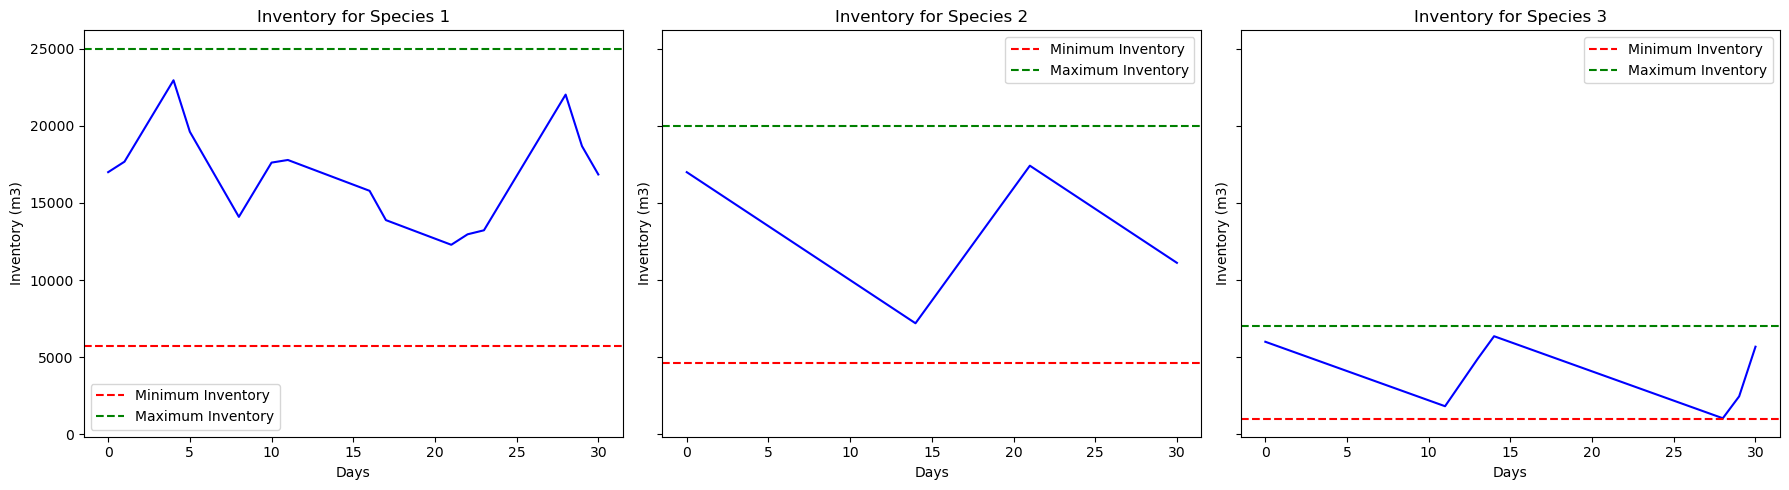

In [8]:
# Inventory Plots
fig, axes = plt.subplots(1, Species, figsize=(18, 5), sharey=True)

for specie in range(Species):
    inventory_per_day = [I[specie, day].X for day in range(Days + 1)]
    
    axes[specie].plot(range(Days + 1), inventory_per_day, color="blue")
    
    axes[specie].axhline(Minimum_inventory[specie], color='red', linestyle='--', label="Minimum Inventory")
    axes[specie].axhline(Maximum_inventory[specie], color='green', linestyle='--', label="Maximum Inventory")
    
    axes[specie].set_title(f"Inventory for Species {specie + 1}")
    axes[specie].set_xlabel("Days")
    axes[specie].set_ylabel("Inventory (m3)")
    axes[specie].legend()

plt.tight_layout()
plt.show()

#### Total Inventory Accumulated

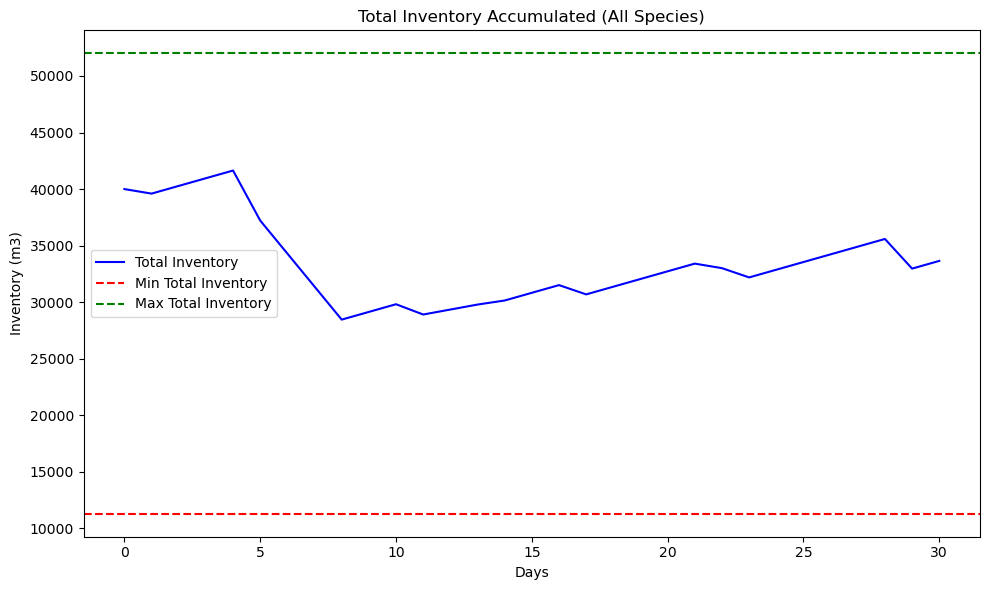

In [9]:
total_inventory = [sum(I[specie, day].X for specie in range(Species)) for day in range(Days + 1)]

# Plot total inventory accumulated over all species
plt.figure(figsize=(10, 6))
plt.plot(range(Days + 1), total_inventory, label="Total Inventory", color="blue")
plt.axhline(np.sum(Minimum_inventory), color='red', linestyle='--', label="Min Total Inventory")
plt.axhline(np.sum(Maximum_inventory), color='green', linestyle='--', label="Max Total Inventory")
plt.title("Total Inventory Accumulated (All Species)")
plt.xlabel("Days")
plt.ylabel("Inventory (m3)")
plt.legend()
plt.tight_layout()
plt.show()

#### Plot Production per Line in Hours

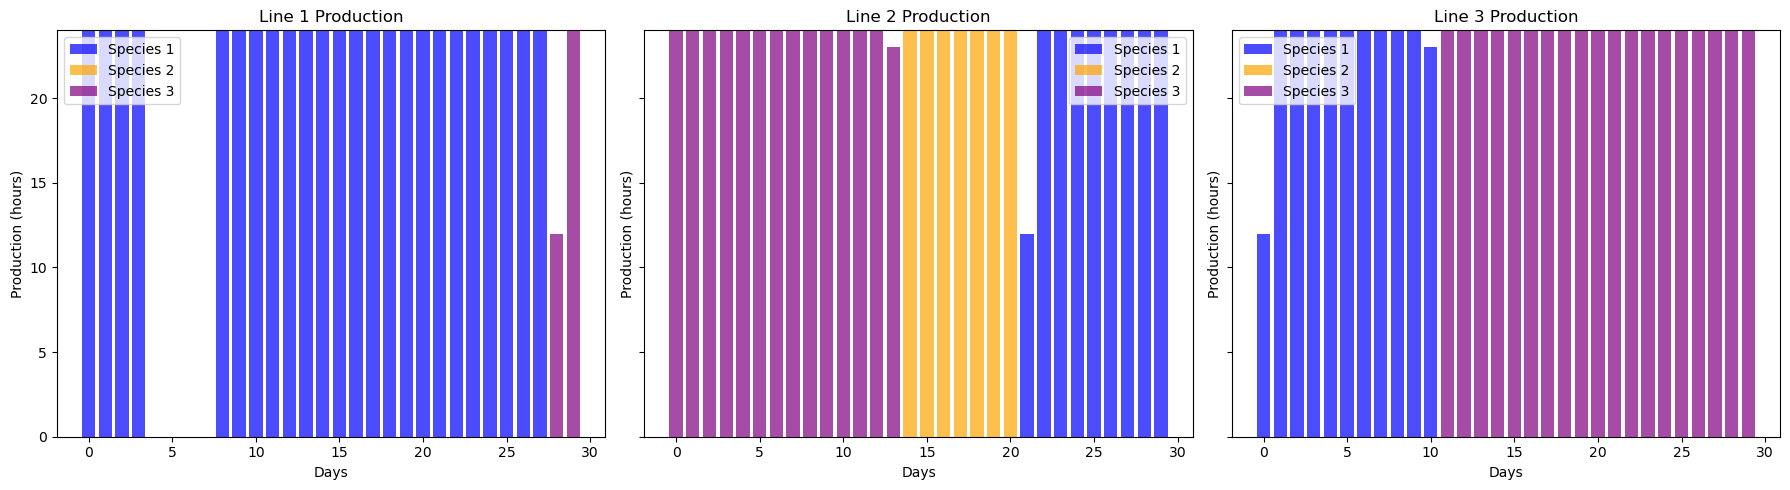

In [10]:
fig, axes = plt.subplots(1, Lines, figsize=(18, 5), sharey=True)
colors = ['blue', 'orange', 'purple']  

for line in range(Lines):
    # Initialize the bottom for stacking bars
    bottom = np.zeros(Days)
    for specie in range(Species):
        # Extract production data from the Gurobi variables
        production_data = [x[specie, line, day].X for day in range(Days)]
        
        # Plot the production data for this line and species
        axes[line].bar(
            range(Days),
            production_data,
            color=colors[specie],
            label=f"Species {specie + 1}",
            alpha=0.7,
            bottom=bottom
        )
        # Update the bottom for the next species
        bottom += production_data
        
    axes[line].set_title(f"Line {line + 1} Production")
    axes[line].set_xlabel("Days")
    axes[line].set_ylabel("Production (hours)")
    axes[line].legend()

plt.tight_layout()
plt.show()

#### Plot Production per Line in m3

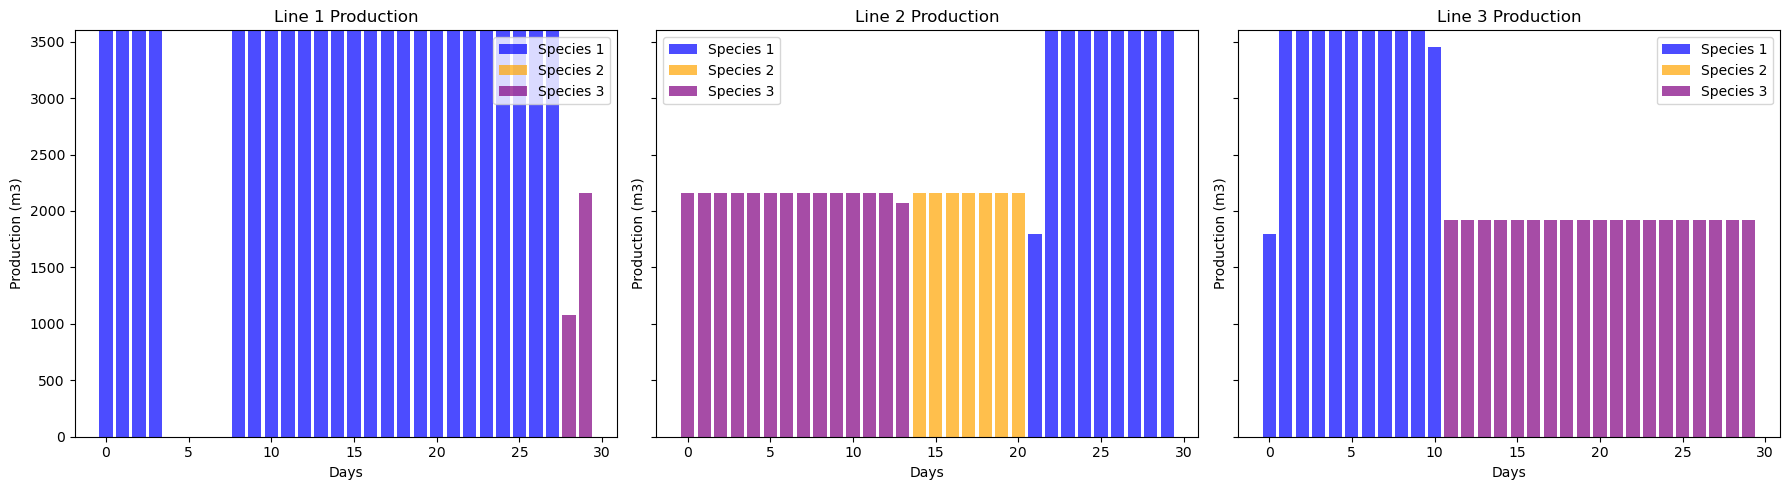

In [11]:
fig, axes = plt.subplots(1, Lines, figsize=(18, 5), sharey=True)
colors = ['blue', 'orange', 'purple']  # Colors for different species

for line in range(Lines):
    # Initialize the bottom for stacking bars
    bottom = np.zeros(Days)
    for specie in range(Species):
        # Extract production data from the Gurobi variables
        production_data = [(x[specie, line, day].X*Re[line][specie]) for day in range(Days)]
        
        # Plot the production data for this line and species
        axes[line].bar(
            range(Days),
            production_data,
            color=colors[specie],
            label=f"Species {specie + 1}",
            alpha=0.7,
            bottom=bottom
        )
        # Update the bottom for the next species
        bottom += production_data
    
    axes[line].set_title(f"Line {line + 1} Production")
    axes[line].set_xlabel("Days")
    axes[line].set_ylabel("Production (m3)")
    axes[line].legend()

plt.tight_layout()
plt.show()

#### Setup Changes Per Line Per Day

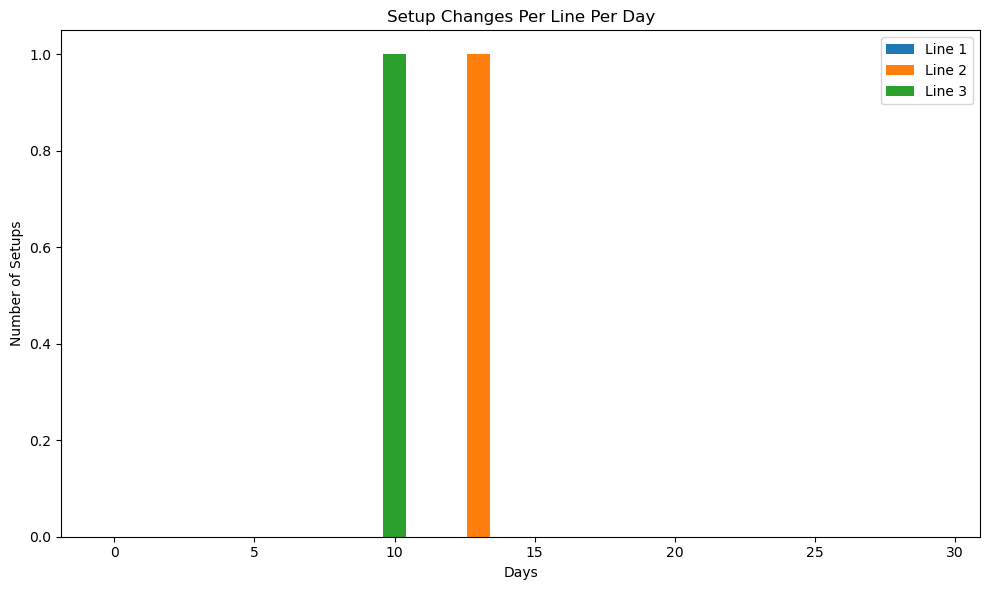

In [12]:
# Matrix to store the setups
Setup_counts_corrected = np.zeros((Lines, Days))

# Extract the setup values from the model
for line in range(Lines):
    for day in range(Days):
        Setup_counts_corrected[line, day] = s[line, day].X

# Plot setup changes
fig, ax = plt.subplots(figsize=(10, 6))
for line in range(Lines):
    ax.bar(range(Days), Setup_counts_corrected[line, :], label=f"Line {line + 1}")

ax.set_title("Setup Changes Per Line Per Day")
ax.set_xlabel("Days")
ax.set_ylabel("Number of Setups")
ax.legend()
plt.tight_layout()
plt.show()


#### Time Usage Per Line

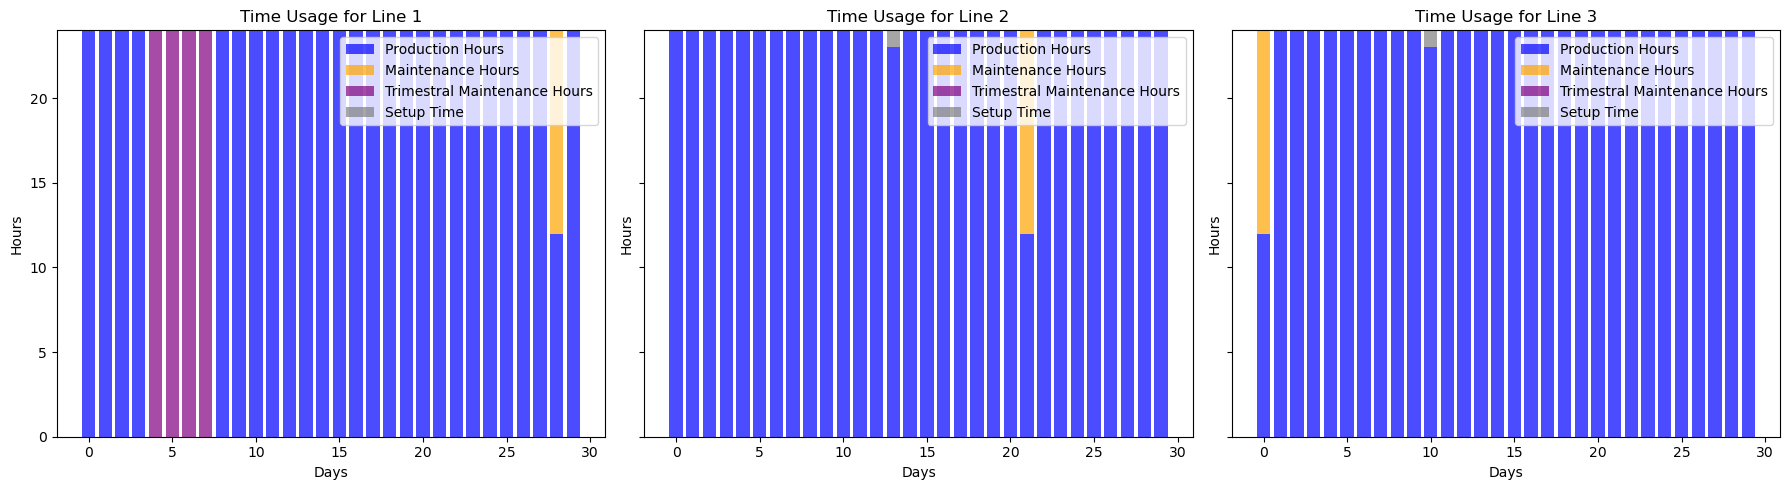

In [13]:
Production_hours = np.zeros((Lines, Days))
Maintenance_hours = np.zeros((Lines, Days))
Trimestral_hours = np.zeros((Lines, Days))
Idle_hours = np.zeros((Lines, Days))

# Extract data from Gurobi variables
for line in range(Lines):
    for day in range(Days):
        # Sum production hours across all species for this line and day
        Production_hours[line, day] = sum(x[specie, line, day].X for specie in range(Species))
        # Maintenance hours
        Maintenance_hours[line, day] = Time_maintenance * M[line, day].X
        # Trimestral maintenance hours
        Trimestral_hours[line, day] = Time_trimestral * Mtri[line, day].X
        # Calculate idle hours
        Idle_hours[line, day] = T - (Production_hours[line, day] + Maintenance_hours[line, day] + Trimestral_hours[line, day])

# Plot time usage for each line
fig, axes = plt.subplots(1, Lines, figsize=(18, 5), sharey=True)
for line in range(Lines):
    axes[line].bar(range(Days), Production_hours[line, :], label="Production Hours", color="blue", alpha=0.7)
    axes[line].bar(range(Days), Maintenance_hours[line, :], label="Maintenance Hours", color="orange", alpha=0.7,
                   bottom=Production_hours[line, :])
    axes[line].bar(range(Days), Trimestral_hours[line, :], label="Trimestral Maintenance Hours", color="purple", alpha=0.7,
                   bottom=Production_hours[line, :] + Maintenance_hours[line, :])
    axes[line].bar(range(Days), Idle_hours[line, :], label="Setup Time", color="gray", alpha=0.7,
                   bottom=Production_hours[line, :] + Maintenance_hours[line, :] + Trimestral_hours[line, :])
    axes[line].set_title(f"Time Usage for Line {line + 1}")
    axes[line].set_xlabel("Days")
    axes[line].set_ylabel("Hours")
    axes[line].legend()

plt.tight_layout()
plt.show()

#### References

Avilés, F. N., Etchepare, R. M., Aguayo, M. M., & Valenzuela, M. (2022). A mixed-integer programming model for an integrated production planning problem with preventive maintenance in the pulp and paper industry. Engineering Optimization, 55(8), 1352–1369. https://doi.org/10.1080/0305215X.2022.2086237